<a href="https://colab.research.google.com/github/clementino1971/BirdCLEF_2020/blob/master/MultiscaleCNNTripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from keras.models import Sequential
#from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

#Data: Import and treat

In [2]:
#Getting the data in .json
data = pd.read_json('/content/drive/My Drive/Colab Notebooks/train.json',)
data.head()

,input,class
0,"[[[36, 52, 54], [53, 55, 55], [58, 59, 50], [4...",drwtyr1
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",drwtyr1
2,"[[[0, 13, 39], [49, 47, 52], [50, 52, 51], [46...",drwtyr1
3,"[[[0, 0, 0], [0, 0, 2], [0, 0, 0], [2, 2, 6], ...",drwtyr1
4,"[[[22, 68, 92], [100, 73, 71], [72, 71, 77], [...",drwtyr1


In [0]:
mapa = {}
top = data['class']
top = top.unique()

cont = 0
for i in top:
  mapa[i] = cont
  cont +=1

data['class'] = data['class'].map(lambda s: mapa[s] if s in mapa else s)

In [0]:
X = [x for x in data['input']]
Y = [y for y in data['class']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Model


###Deep Metric Learning


In [0]:
#Template of Multiscale Analysis Module
def MAM(in_mam):
  str1 = layers.Conv2D(64,kernel_size=(1,1),padding="same",activation='relu')(in_mam)

  str2 = layers.Conv2D(32,kernel_size=(1,1),padding="same",activation='relu')(in_mam)
  str2 = layers.Conv2D(64,kernel_size=(3,3),padding="same",activation='relu')(str2)

  str3 = layers.Conv2D(32,kernel_size=(1,1),padding="same",activation='relu')(in_mam)
  str3 = layers.Conv2D(64,kernel_size=(5,5),padding="same",activation='relu')(str3)

  str4 = layers.Conv2D(32,kernel_size=(1,1),padding="same",activation='relu')(in_mam)
  str4 = layers.Conv2D(64,kernel_size=(7,7),padding="same",activation='relu')(str4)

  mam = layers.concatenate([str1,str2,str3,str4])
  return mam

#BEGIN OF MULTISCALE CNN
Input = keras.Input(shape=(40, 200, 3))

#CONV1
x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1),padding="same",activation='relu')(Input)
#MAM1
x = MAM(x)
#CONV2
x = layers.Conv2D(64, kernel_size=3,strides=(2,1),padding="same",activation='relu')(x)
#MAM2
x = MAM(x)
#CONV3
x = layers.Conv2D(64, kernel_size=3,strides=(2,1),padding="same",activation='relu')(x)
#MAM1
x = MAM(x)
#CONV4
x = layers.Conv2D(64, kernel_size=3,strides=(2,1),padding="same",activation='relu')(x)
#MAM1
x = MAM(x)
#CONV5
x = layers.Conv2D(64, kernel_size=3,strides=(5,1), padding="same",activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256,activation='relu',kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128,activation='relu',kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.4)(x)
emb128 = layers.Dense(128,activation='linear',kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

model1 = keras.Model(inputs=Input, outputs=emb128, name="Multiscale_CNN")

#To see the summary of model uncoment here
#model1.summary()
#To see a plot of model uncoment here
#keras.utils.plot_model(model1, "deep_metric_learning.png", show_shapes=True)

In [0]:
model1.compile(
    optimizer=keras.optimizers.Adagrad(),
    loss=tfa.losses.TripletSemiHardLoss())

In [8]:
history = model1.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
40/40 [==============================] - 709s 18s/step - loss: 1.1889
Epoch 2/5
40/40 [==============================] - 685s 17s/step - loss: 0.7314
Epoch 3/5
40/40 [==============================] - 673s 17s/step - loss: 0.7801
Epoch 4/5
40/40 [==============================] - 688s 17s/step - loss: 0.6897
Epoch 5/5
40/40 [==============================] - 715s 18s/step - loss: 0.6596


In [0]:
#getting embeddinds from the Multiscale CNN trained
embeddings = model1.predict(X_train)

#Uncoment here to save the model in the Disk

# serialize model to JSON
#model_json = model1.to_json()
#with open("/content/drive/My Drive/Colab Notebooks/model1.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model1.save_weights("/content/drive/My Drive/Colab Notebooks/model.h5")
#print("Saved model to disk")

###Classification (MPL architeture)



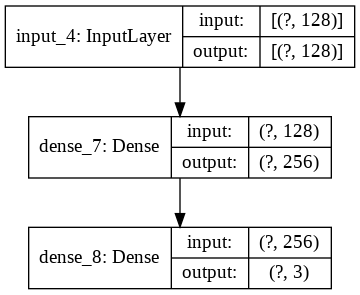

In [74]:
#Input Layer
Input = keras.Input(shape=(128))
#Hidden Layer
x = layers.Dense(units=256,activation='relu')(Input)
#Output to 3 Classes
x = layers.Dense(units=3,activation='softmax')(x)

model2 = keras.Model(inputs=Input, outputs=x, name="MLP")

#To see the summary of model uncoment here
#model2.summary()
#To see a plot of model uncoment here
#keras.utils.plot_model(model2, "classification.png", show_shapes=True)

In [0]:
model2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
    )

In [78]:
y_train_onehot = keras.utils.to_categorical(y_train)

history = model2.fit(embeddings, y_train_onehot, batch_size=256,epochs=100)

Epoch 1/100
5/5 [==============================] - 0s 3ms/step - loss: 0.4945 - accuracy: 0.8871
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.4607 - accuracy: 0.8863
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.4318 - accuracy: 0.8879
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 0.4081 - accuracy: 0.8879
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3880 - accuracy: 0.8887
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3728 - accuracy: 0.8856
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8903
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3472 - accuracy: 0.8911
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3368 - accuracy: 0.8934
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3289 - accuracy: 0.8919
Epoch 11/100
5/5 [===========

In [0]:
#Uncoment here to save the model in the Disk

# serialize model to JSON
#model_json = model2.to_json()
#with open("/content/drive/My Drive/Colab Notebooks/model2.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model2.save_weights("/content/drive/My Drive/Colab Notebooks/model2.h5")
#print("Saved model to disk")

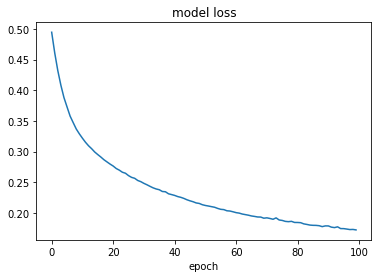

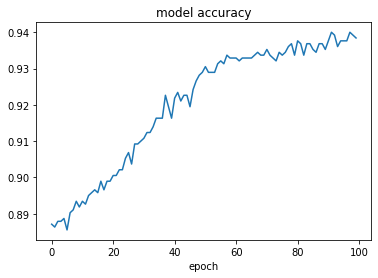

In [122]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.show()


#Test



In [0]:
#Embeddings From Multiscale CNN
embeddings_train = model1.predict(X_train)
embeddings_teste = model1.predict(X_test)

In [0]:
#Predict from MLP
y_train_pred = model2.predict(embeddings_train)
y_teste_pred = model2.predict(embeddings_teste)

In [0]:
#Transforming percent predictions to choose one classe
def my_predict(y_in_perc):
  n_pred = np.zeros(len(y_in_perc),dtype=int) 
  for i in range(len(y_in_perc)):  
      if(y_in_perc[i].max() > 0.5):
        n_pred[i] = y_in_perc[i].argmax()
      else:
        n_pred[i] = -1
  return n_pred 


y_train_pred = my_predict(y_train_pred)
y_teste_pred = my_predict(y_teste_pred) 


In [114]:
# calculate training accuracy
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]

print(f'Training accuracy: {(train_acc * 100):.2f}')

# calculate testing accuracy
correct_preds = np.sum(y_test == y_teste_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]

print(f'Test accuracy: {(test_acc * 100):.2f}')

Training accuracy: 92.82
Test accuracy: 92.43
